<a href="https://colab.research.google.com/github/visheshrao17/CIFAR-Experimentation-/blob/main/CNN_CIAFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

print("Libraries imported and transformations defined.")

Libraries imported and transformations defined.


In [14]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_subset_size = 10000
test_subset_size = 2000

# Create a subset of the training dataset
train_indices = torch.randperm(len(trainset))[:train_subset_size]
train_subset = Subset(trainset, train_indices)

# Create a subset of the test dataset
test_indices = torch.randperm(len(testset))[:test_subset_size]
test_subset = Subset(testset, test_indices)

# Define batch size
batch_size = 64

# Create DataLoader instances
trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"CIFAR-10 training dataset loaded with {len(train_subset)} samples.")
print(f"CIFAR-10 test dataset loaded with {len(test_subset)} samples.")
print(f"DataLoader instances created with batch size {batch_size}.")

CIFAR-10 training dataset loaded with 10000 samples.
CIFAR-10 test dataset loaded with 2000 samples.
DataLoader instances created with batch size 64.


In [15]:
import torch.nn as nn
import torch.nn.functional as F

# Define a Convolutional Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5) 
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print("CNN model architecture defined.")

CNN model architecture defined.


In [16]:
import torch.optim as optim

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  

        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step() 

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

print("Training and validation functions defined.")

Training and validation functions defined.


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define hyperparameters to experiment with
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]
num_epochs_list = [5, 10]

best_val_accuracy = 0.0
best_hyperparameters = {}

results = []

for lr in learning_rates:
    for bs in batch_sizes:
        for epochs in num_epochs_list:
            print(f"\n--- Experimenting with LR: {lr}, Batch Size: {bs}, Epochs: {epochs} ---")

            # Re-initialize model and optimizer for each experiment
            model = Net().to(device)
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            # Create new DataLoader instances with current batch size
            trainloader_exp = DataLoader(train_subset, batch_size=bs, shuffle=True)
            testloader_exp = DataLoader(test_subset, batch_size=bs, shuffle=False)

            # Lists to store metrics for the current hyperparameter combination
            current_train_losses = []
            current_train_accuracies = []
            current_val_losses = []
            current_val_accuracies = []
            
            for epoch in range(epochs):
                # Train the model for one epoch
                train_loss, train_acc = train_epoch(model, trainloader_exp, criterion, optimizer, device)
                current_train_losses.append(train_loss)
                current_train_accuracies.append(train_acc)

                # Validate the model
                val_loss, val_acc = validate_epoch(model, testloader_exp, criterion, device)
                current_val_losses.append(val_loss)
                current_val_accuracies.append(val_acc)

                print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # Store results for this combination
            results.append({
                'learning_rate': lr,
                'batch_size': bs,
                'num_epochs': epochs,
                'train_losses': current_train_losses,
                'train_accuracies': current_train_accuracies,
                'val_losses': current_val_losses,
                'val_accuracies': current_val_accuracies
            })

            # Check if this model is the best performing one
            if current_val_accuracies[-1] > best_val_accuracy:
                best_val_accuracy = current_val_accuracies[-1]
                best_hyperparameters = {
                    'learning_rate': lr,
                    'batch_size': bs,
                    'num_epochs': epochs
                }
                # Optionally, save the best model state here
                # torch.save(model.state_dict(), 'best_model.pth')

print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f} with Hyperparameters: {best_hyperparameters}")

Using device: cpu

--- Experimenting with LR: 0.01, Batch Size: 32, Epochs: 5 ---
Epoch 1/5 | Train Loss: 2.1553, Train Acc: 0.1909 | Val Loss: 1.9075, Val Acc: 0.2965
Epoch 2/5 | Train Loss: 1.7479, Train Acc: 0.3611 | Val Loss: 1.6965, Val Acc: 0.3945
Epoch 3/5 | Train Loss: 1.5909, Train Acc: 0.4167 | Val Loss: 1.5443, Val Acc: 0.4490
Epoch 4/5 | Train Loss: 1.4528, Train Acc: 0.4684 | Val Loss: 1.5022, Val Acc: 0.4585
Epoch 5/5 | Train Loss: 1.3694, Train Acc: 0.4984 | Val Loss: 1.5150, Val Acc: 0.4660

--- Experimenting with LR: 0.01, Batch Size: 32, Epochs: 10 ---
Epoch 1/10 | Train Loss: 2.1552, Train Acc: 0.1917 | Val Loss: 1.9281, Val Acc: 0.2915
Epoch 2/10 | Train Loss: 1.7974, Train Acc: 0.3336 | Val Loss: 1.6711, Val Acc: 0.3945
Epoch 3/10 | Train Loss: 1.6180, Train Acc: 0.4056 | Val Loss: 1.5948, Val Acc: 0.4055
Epoch 4/10 | Train Loss: 1.4963, Train Acc: 0.4467 | Val Loss: 1.4840, Val Acc: 0.4740
Epoch 5/10 | Train Loss: 1.4130, Train Acc: 0.4813 | Val Loss: 1.4624, Val 

## Baseline Model Results Summary

In [18]:
import pandas as pd

# Create summary of baseline experiments (without augmentation)
summary_data = []

for res in results:
    summary_data.append({
        'Learning Rate': res['learning_rate'],
        'Batch Size': res['batch_size'],
        'Num Epochs': res['num_epochs'],
        'Final Val Accuracy': res['val_accuracies'][-1],
        'Final Val Loss': res['val_losses'][-1]
    })

summary_df = pd.DataFrame(summary_data)

print("\n=== Baseline Model Results (Without Data Augmentation) ===")
display(summary_df.round(4))

print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Best Hyperparameters: {best_hyperparameters}")


=== Baseline Model Results (Without Data Augmentation) ===


,Learning Rate,Batch Size,Num Epochs,Final Val Accuracy,Final Val Loss
0,0.010,32,5,0.4660,1.5150
1,0.010,32,10,0.5235,1.4260
2,0.010,64,5,0.4500,1.5279
3,0.010,64,10,0.5105,1.3674
4,0.001,32,5,0.2090,2.1374
5,0.001,32,10,0.3405,1.8416
6,0.001,64,5,0.1285,2.2939
7,0.001,64,10,0.2765,2.0166



Best Validation Accuracy: 0.5235
Best Hyperparameters: {'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10}


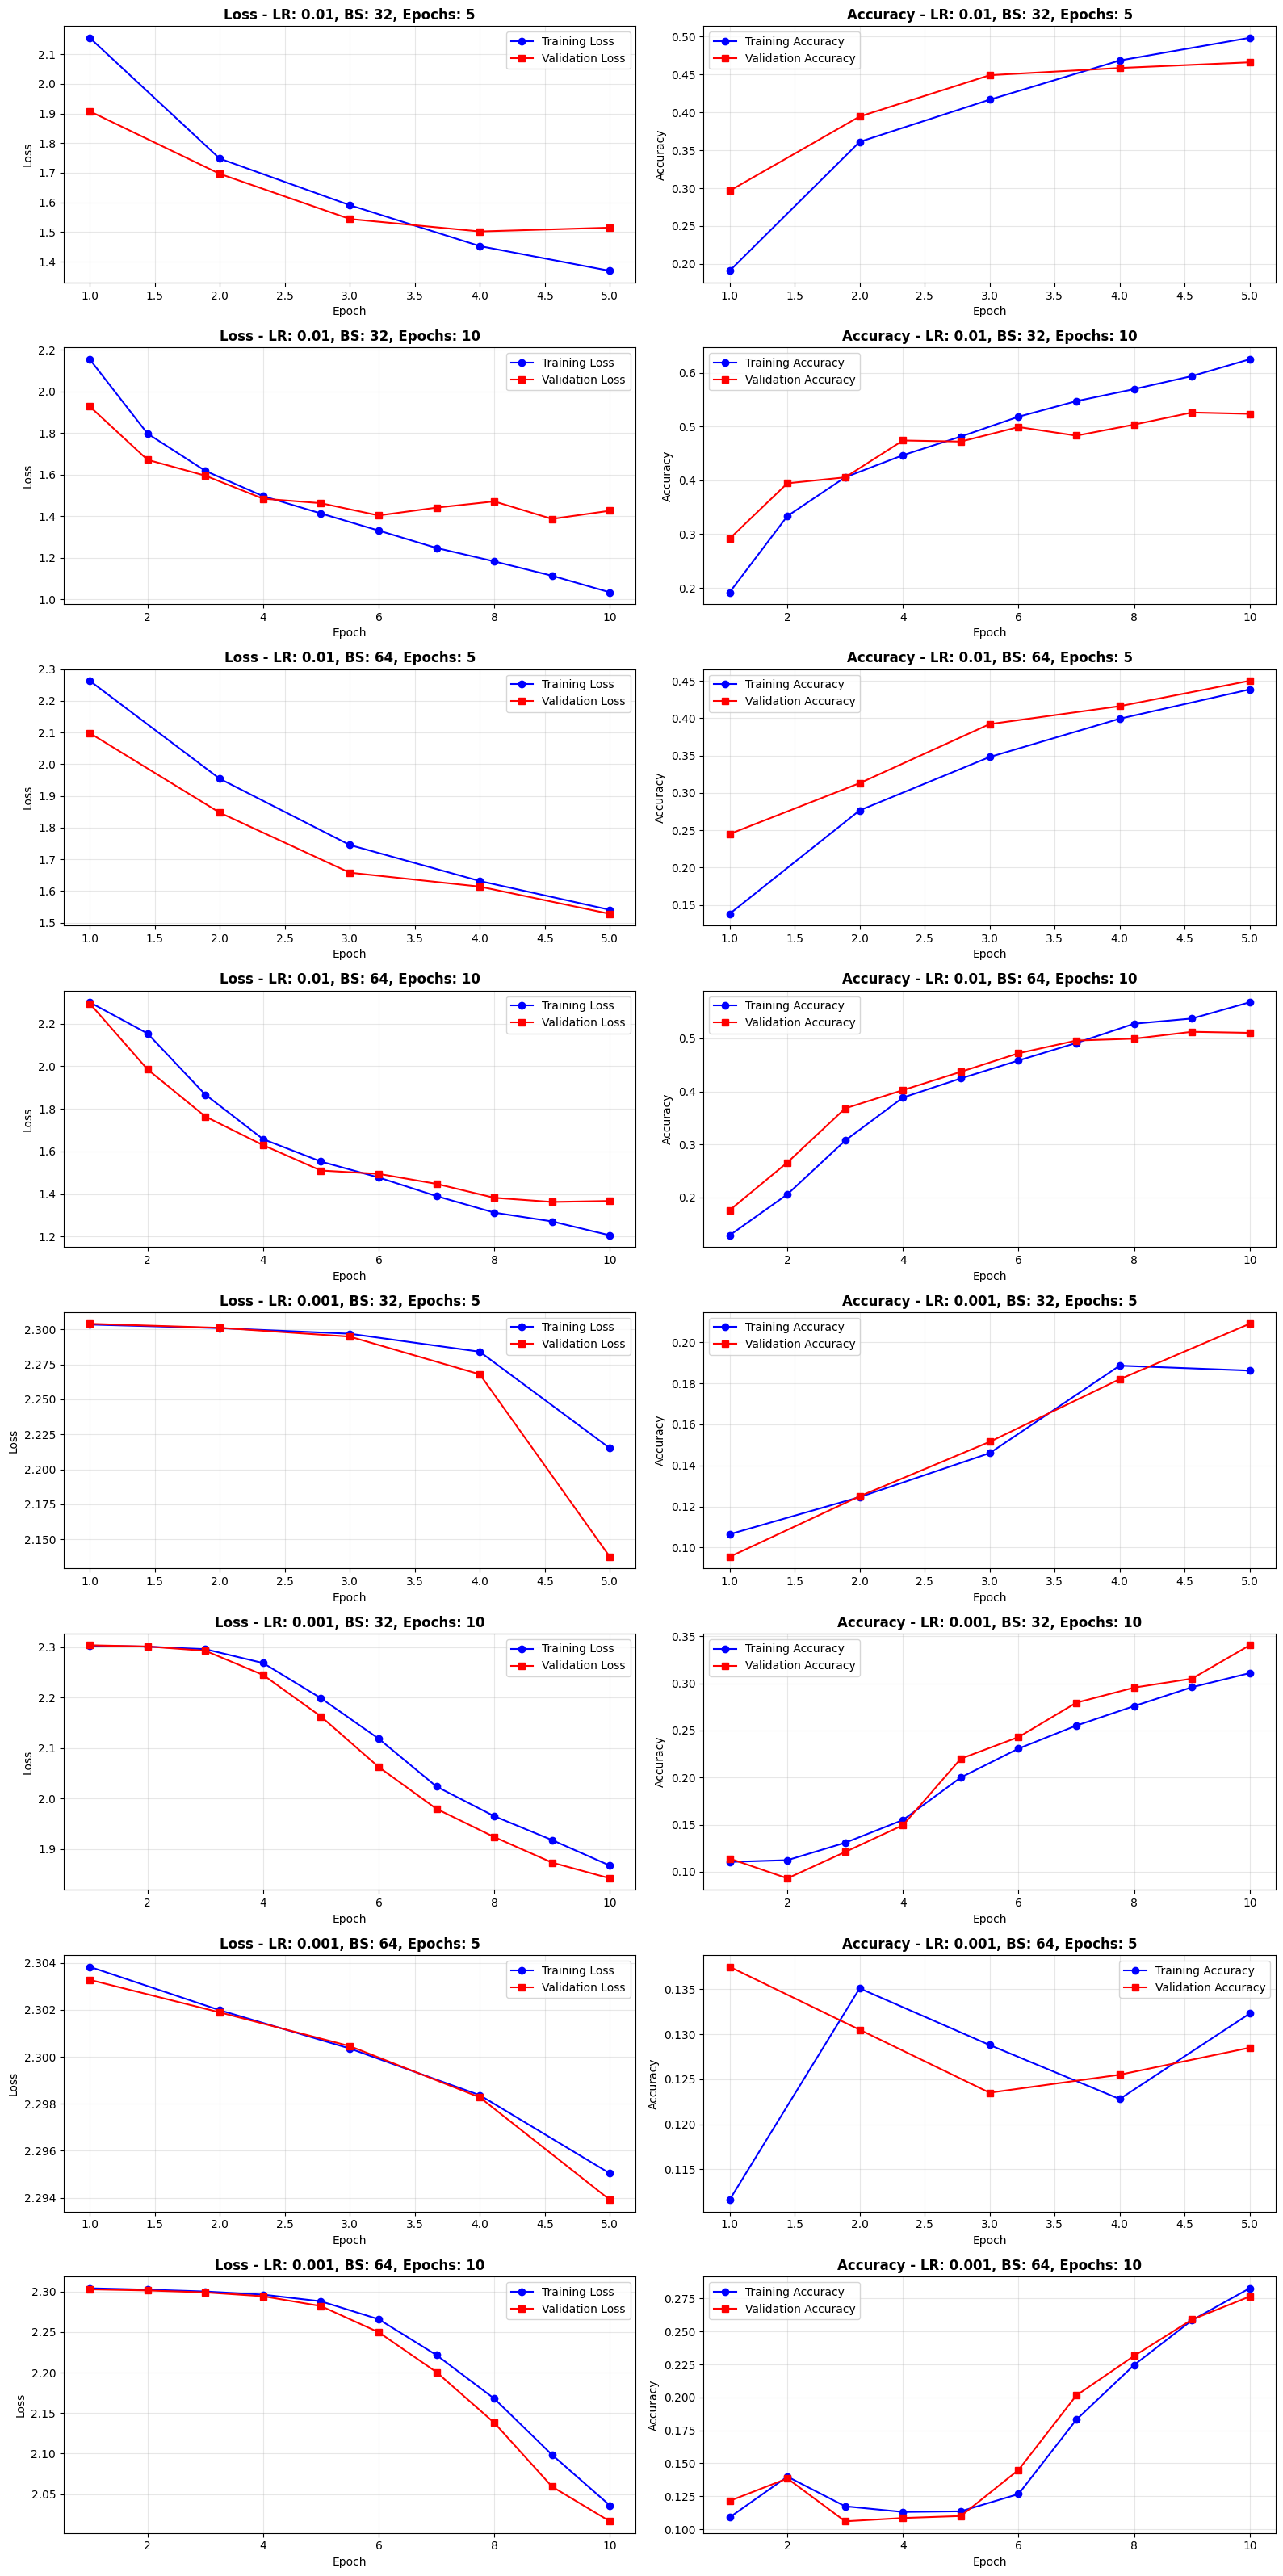

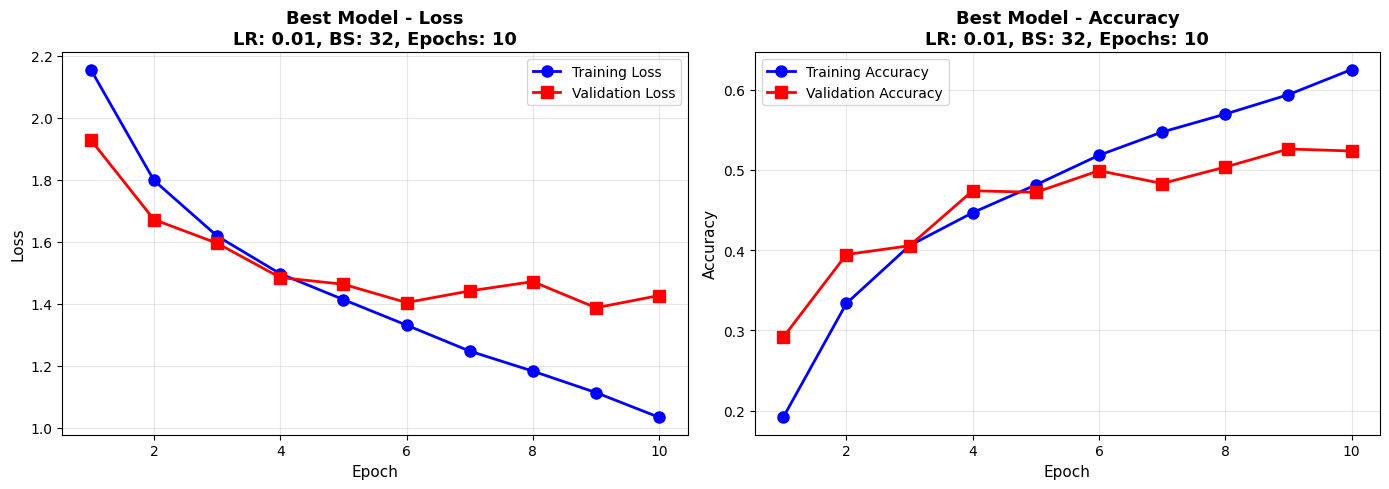

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Plot Training Curves for Each Hyperparameter Combination
fig, axes = plt.subplots(len(results), 2, figsize=(16, 4*len(results)))

if len(results) == 1:
    axes = axes.reshape(1, -1)

for idx, res in enumerate(results):
    lr = res['learning_rate']
    bs = res['batch_size']
    epochs = res['num_epochs']
    
    # Plot Loss
    axes[idx, 0].plot(range(1, epochs+1), res['train_losses'], 'b-', label='Training Loss', marker='o')
    axes[idx, 0].plot(range(1, epochs+1), res['val_losses'], 'r-', label='Validation Loss', marker='s')
    axes[idx, 0].set_title(f'Loss - LR: {lr}, BS: {bs}, Epochs: {epochs}', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot Accuracy
    axes[idx, 1].plot(range(1, epochs+1), res['train_accuracies'], 'b-', label='Training Accuracy', marker='o')
    axes[idx, 1].plot(range(1, epochs+1), res['val_accuracies'], 'r-', label='Validation Accuracy', marker='s')
    axes[idx, 1].set_title(f'Accuracy - LR: {lr}, BS: {bs}, Epochs: {epochs}', fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Accuracy')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Best Model Training Curves (Detailed)
best_result = max(results, key=lambda x: max(x['val_accuracies']))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = best_result['num_epochs']
axes[0].plot(range(1, epochs+1), best_result['train_losses'], 'b-', label='Training Loss', marker='o', linewidth=2, markersize=8)
axes[0].plot(range(1, epochs+1), best_result['val_losses'], 'r-', label='Validation Loss', marker='s', linewidth=2, markersize=8)
axes[0].set_title(f"Best Model - Loss\nLR: {best_result['learning_rate']}, BS: {best_result['batch_size']}, Epochs: {epochs}", 
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, epochs+1), best_result['train_accuracies'], 'b-', label='Training Accuracy', marker='o', linewidth=2, markersize=8)
axes[1].plot(range(1, epochs+1), best_result['val_accuracies'], 'r-', label='Validation Accuracy', marker='s', linewidth=2, markersize=8)
axes[1].set_title(f"Best Model - Accuracy\nLR: {best_result['learning_rate']}, BS: {best_result['batch_size']}, Epochs: {epochs}", 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

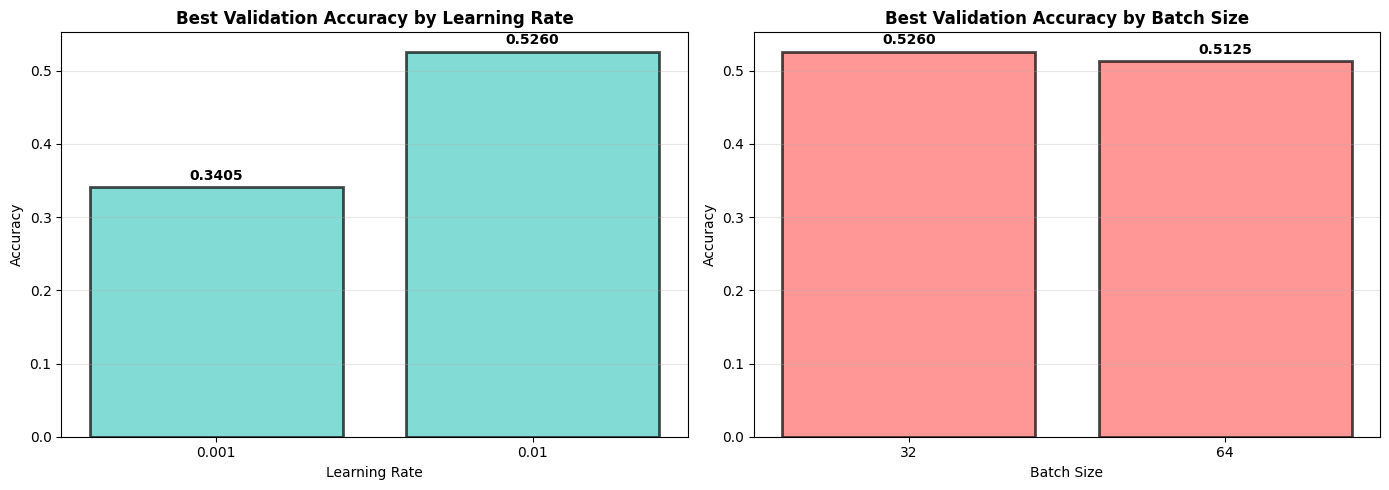

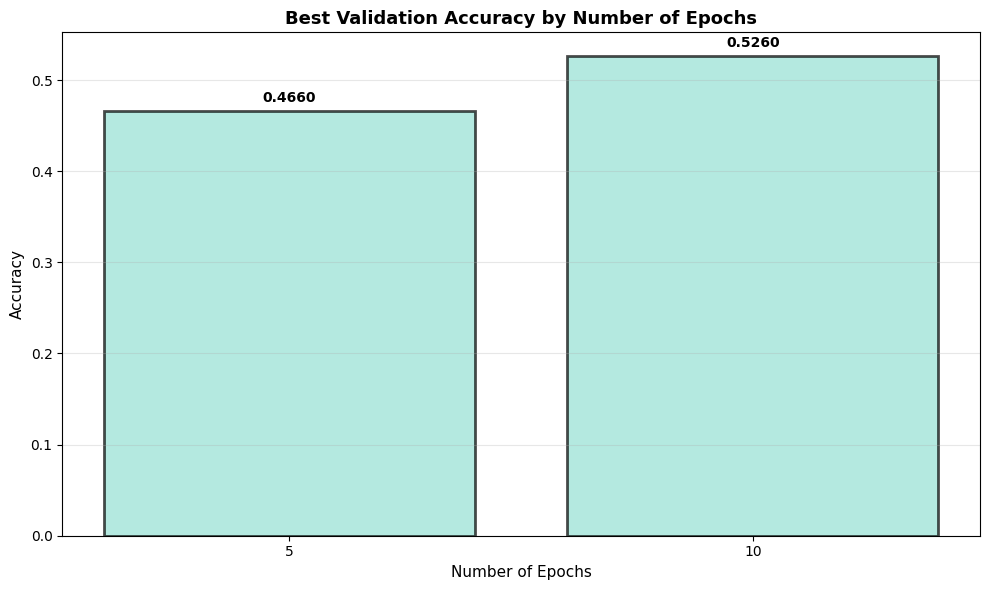

In [23]:
# 3. Compare Best Accuracy for Each Learning Rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

learning_rates_list = sorted(set(res['learning_rate'] for res in results))
best_acc_by_lr = []

for lr in learning_rates_list:
    lr_results = [res for res in results if res['learning_rate'] == lr]
    best_acc = max(max(res['val_accuracies']) for res in lr_results)
    best_acc_by_lr.append(best_acc)

axes[0].bar(range(len(learning_rates_list)), best_acc_by_lr, color='#4ECDC4', alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_xticks(range(len(learning_rates_list)))
axes[0].set_xticklabels(learning_rates_list)
axes[0].set_title('Best Validation Accuracy by Learning Rate', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Accuracy')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(best_acc_by_lr):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# 4. Compare Best Accuracy for Each Batch Size
batch_sizes_list = sorted(set(res['batch_size'] for res in results))
best_acc_by_bs = []

for bs in batch_sizes_list:
    bs_results = [res for res in results if res['batch_size'] == bs]
    best_acc = max(max(res['val_accuracies']) for res in bs_results)
    best_acc_by_bs.append(best_acc)

axes[1].bar(range(len(batch_sizes_list)), best_acc_by_bs, color='#FF6B6B', alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_xticks(range(len(batch_sizes_list)))
axes[1].set_xticklabels(batch_sizes_list)
axes[1].set_title('Best Validation Accuracy by Batch Size', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Accuracy')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(best_acc_by_bs):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Compare Best Accuracy for Each Epoch Count
fig, ax = plt.subplots(figsize=(10, 6))

epochs_list = sorted(set(res['num_epochs'] for res in results))
best_acc_by_epochs = []

for ep in epochs_list:
    ep_results = [res for res in results if res['num_epochs'] == ep]
    best_acc = max(max(res['val_accuracies']) for res in ep_results)
    best_acc_by_epochs.append(best_acc)

ax.bar(range(len(epochs_list)), best_acc_by_epochs, color='#95E1D3', alpha=0.7, edgecolor='black', linewidth=2)
ax.set_xticks(range(len(epochs_list)))
ax.set_xticklabels(epochs_list)
ax.set_title('Best Validation Accuracy by Number of Epochs', fontsize=13, fontweight='bold')
ax.set_xlabel('Number of Epochs', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(best_acc_by_epochs):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 6. Create a Heatmap of Final Validation Accuracy for Different Hyperparameter Combinations
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize=(12, 8))

# Organize data for heatmap
learning_rates_list = sorted(set(res['learning_rate'] for res in results))
batch_sizes_list = sorted(set(res['batch_size'] for res in results))
epochs_list = sorted(set(res['num_epochs'] for res in results))

# Create a matrix for visualization (using first epoch count as example)
heatmap_data = np.zeros((len(batch_sizes_list), len(learning_rates_list)))

for i, bs in enumerate(batch_sizes_list):
    for j, lr in enumerate(learning_rates_list):
        # Get first epochs result for this LR, BS combination
        matching_results = [res for res in results if res['learning_rate'] == lr and res['batch_size'] == bs]
        if matching_results:
            heatmap_data[i, j] = max(max(res['val_accuracies']) for res in matching_results)

im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(learning_rates_list)))
ax.set_yticks(range(len(batch_sizes_list)))
ax.set_xticklabels(learning_rates_list)
ax.set_yticklabels(batch_sizes_list)
ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('Batch Size', fontsize=12, fontweight='bold')
ax.set_title('Validation Accuracy Heatmap (Learning Rate vs Batch Size)', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(len(batch_sizes_list)):
    for j in range(len(learning_rates_list)):
        text = ax.text(j, i, f'{heatmap_data[i, j]:.3f}',
                      ha="center", va="center", color="black", fontweight='bold', fontsize=11)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Accuracy', rotation=270, labelpad=20, fontweight='bold')

plt.tight_layout()
plt.show()

# 7. Final Validation Loss Comparison for All Experiments
fig, ax = plt.subplots(figsize=(14, 8))

experiment_labels = [f"LR:{r['learning_rate']}\nBS:{r['batch_size']}\nE:{r['num_epochs']}" for r in results]
final_val_losses = [r['val_losses'][-1] for r in results]

colors_loss = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(final_val_losses)))
bars = ax.bar(range(len(final_val_losses)), final_val_losses, color=colors_loss, alpha=0.8, edgecolor='black', linewidth=2)

ax.set_xticks(range(len(final_val_losses)))
ax.set_xticklabels(experiment_labels, fontsize=9)
ax.set_title('Final Validation Loss Comparison Across All Experiments', fontsize=13, fontweight='bold')
ax.set_ylabel('Validation Loss', fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, loss) in enumerate(zip(bars, final_val_losses)):
    ax.text(bar.get_x() + bar.get_width()/2, loss + 0.02, f'{loss:.4f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# 8. Final Validation Accuracy Comparison for All Experiments
fig, ax = plt.subplots(figsize=(14, 8))

final_val_accuracies = [r['val_accuracies'][-1] for r in results]

colors_acc = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(final_val_accuracies)))
bars = ax.bar(range(len(final_val_accuracies)), final_val_accuracies, color=colors_acc, alpha=0.8, edgecolor='black', linewidth=2)

ax.set_xticks(range(len(final_val_accuracies)))
ax.set_xticklabels(experiment_labels, fontsize=9)
ax.set_title('Final Validation Accuracy Comparison Across All Experiments', fontsize=13, fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, final_val_accuracies)):
    ax.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f'{acc:.4f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"✓ All visualizations displayed successfully")
print(f"{'='*60}")

✓ Saved: ../results/05_accuracy_heatmap.png
✓ Saved: ../results/06_final_validation_loss_comparison.png
✓ Saved: ../results/07_final_validation_accuracy_comparison.png

✓ All visualizations saved successfully to: ../results/

Generated files:
  1. 01_training_curves_all.png - Training curves for all experiments
  2. 02_best_model_training_curves.png - Best model details
  3. 03_hyperparameter_comparison.png - LR and BS comparison
  4. 04_epochs_comparison.png - Epochs comparison
  5. 05_accuracy_heatmap.png - Learning rate vs Batch size heatmap
  6. 06_final_validation_loss_comparison.png - Loss comparison
  7. 07_final_validation_accuracy_comparison.png - Accuracy comparison
